# Preprocessing

+ read data
+ encoding the input feature by naive linearly squash.
+ split them into training set, validation set and testing set
+ randomly pick a smalll part of whole dataset, which will be used in EA algorithm

##### Hongbo Zhang

In [1]:
import gzip
import io
import time
import numpy as np
import math
import matplotlib.pyplot as plt

## Read Data

Read `covtype` data.

In [2]:
# read data from covtype.data.gz

datafile = "../data/covtype.data.gz"

gzipfile = gzip.open(datafile, 'rb')

file = io.BufferedReader(gzipfile)

ndata = 581012
rawdata = np.empty((ndata,55))

start = time.time()
i = 0
for line in file:
    rawdata[i] = np.fromstring(line, dtype=int, sep=",")
    i += 1;
    if i % 100000 == 0:
        print("Has read to line: ", i)
end = time.time()

print("use time: ", end-start, " to read data file.")
            
gzipfile.close()

Has read to line:  100000
Has read to line:  200000
Has read to line:  300000
Has read to line:  400000
Has read to line:  500000
use time:  2.111485004425049  to read data file.


In [5]:
print(rawdata.shape)

(581012, 55)


## Preprocess Data

By the most naive preprocessing method: linear squash all data to $[0,1]$ except the last column, which is category target.

In [8]:
# useful functions

def linearSquash(x):
    '''linear squash x into range [0,1]'''
    xmin = min(x)
    xmax = max(x)
    x = (x - xmin)/(xmax - xmin)
    return x

# use most simple linearsquash encoding for all variable except the last column

data = np.copy(rawdata)
for i in range(rawdata.shape[1]-1):
    data[:, i] = linearSquash(rawdata[:,i])

print(data.shape)
print(data[10:12])

(581012, 55)
[[0.37668834 0.55833333 0.06060606 0.12884753 0.28940568 0.10327385
  0.85826772 0.95669291 0.63385827 0.86741949 1.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  5.        ]
 [0.51375688 0.41944444 0.16666667 0.26556908 0.25710594 0.73809189
  0.92125984 0.94488189 0.53543307 0.56475673 1.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         

## Split Data to Training Set, Testing Set and Validation Set

There are 581012 patterns in the dataset.

### Dataset for ANN

These are the dataset for training the ANN

We randomly select 50% of whole dataset as the training set (290506 patterns), 
25% of whole dataset as validation set (145253 patterns) 
and remaining 25% as testing set (145253 patterns)

In ANN training process, the validation set will be used to report learning curve,
however, it is not essential in this case, since the hyperparameter is obtained by EA.

### Dataset for EA

These are the dataset for selecting ANN's hyperparameter by evolutionay algorithm.
Since EA is very expensive, therefore we only take a small part of whole dataset here.

Among the training set for ANN, we take 10% of them to form the training set for EA (29050 patterns).

Among the validation set for ANN, we take 10% of them to form the validation set for EA (14525 patterns).

In hyperparameter selecting by EA, testing set is never used.

In [20]:
# dataset for ANN

# ndata = 20
ndata = 581012
trainindex = np.random.choice(ndata, int(ndata/2), replace=False)
# print(trainindex)
remainindex = np.delete(np.arange(ndata), trainindex)
# print(remainindex)
testindex = np.random.choice(remainindex, size = int(ndata/4), replace = False)
# print(testindex)
valindex = np.setdiff1d(remainindex, testindex)
# print(valindex)

print(trainindex.shape)
print(testindex.shape)
print(valindex.shape)


trainANN = data[trainindex, :]
testANN = data[testindex, :]
valANN = data[valindex, :]

print(trainANN.shape)
print(testANN.shape)
print(valANN.shape)

(290506,)
(145253,)
(145253,)
(290506, 55)
(145253, 55)
(145253, 55)


(array([52596., 71319.,  8930.,   694.,  2302.,  4304.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 6 Patch objects>)

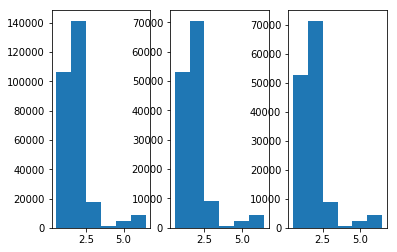

In [22]:
# to see whether train, test and validation set contains nearly equal data from each category
plt.subplot(1,3,1)
plt.hist(trainANN[:,-1], np.array([1,2,3,4,5,6,7])-0.5)
plt.subplot(1,3,2)
plt.hist(testANN[:,-1], np.array([1,2,3,4,5,6,7])-0.5)
plt.subplot(1,3,3)
plt.hist(valANN[:,-1], np.array([1,2,3,4,5,6,7])-0.5)

In [35]:
# Dataset for EA

# 10% of trainANN
indexlist1 = np.random.choice(int(ndata/2), int(ndata/20), replace=False)
# 1% of trainANN
# indexlist1 = np.random.choice(int(ndata/2), int(ndata/200), replace=False)
trainEA = trainANN[indexlist1,:]
# 10% of valANN
indexlist2 = np.random.choice(int(ndata/4), int(ndata/40), replace=False)
# 1% of valANN
# indexlist2 = np.random.choice(int(ndata/4), int(ndata/400), replace=False)
valEA = valANN[indexlist2,:]

print(trainEA.shape)
print(valEA.shape)

(29050, 55)
(14525, 55)


(array([5304., 7153.,  858.,   68.,  229.,  425.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 6 Patch objects>)

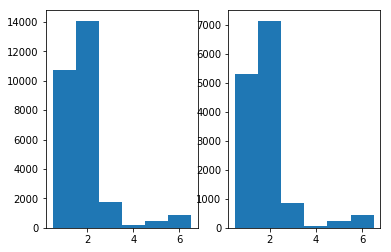

In [36]:
# to see whether train and validation set contains nearly equal data from each category
plt.subplot(1,2,1)
plt.hist(trainEA[:,-1], np.array([1,2,3,4,5,6,7])-0.5)
plt.subplot(1,2,2)
plt.hist(valEA[:,-1], np.array([1,2,3,4,5,6,7])-0.5)

## Storage Data

In [23]:
start = time.time()
np.savetxt("../data/trainANN.data.gz", trainANN, delimiter=',') 
np.savetxt("../data/testANN.data.gz", testANN, delimiter=',') 
np.savetxt("../data/validANN.data.gz", valANN, delimiter=',') 
end = time.time()

print(end-start)

30.635807037353516


In [37]:
start = time.time()
np.savetxt("../data/trainEA.data.gz", trainEA, delimiter=',') 
np.savetxt("../data/validEA.data.gz", valEA, delimiter=',') 
end = time.time()

print(end-start)

2.298041582107544
